In [51]:
#basic import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
from sklearn.metrics import classification_report
import spacy
import warnings
from collections import defaultdict
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
device = torch.device("mps")

### Reading data

In [6]:
df = pd.read_csv('/Users/aadityajoshi/Downloads/depression_dataset_reddit_cleaned.csv')

In [7]:
df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   clean_text     7731 non-null   object
 1   is_depression  7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [9]:
df['text'] = df['clean_text']
df['label'] = df['is_depression']
df.drop(['clean_text','is_depression'],axis=1,inplace=True)

### removing blanks nan and duplicates

In [10]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
blanks = []
for i,txt,lb in df.itertuples():
    if type(txt) == str:
        if txt.isspace() == True:
            blanks.append(i)
print(blanks)
df.drop(blanks,inplace=True)

[]


In [11]:
df['len'] = df['text'].apply(len)

In [13]:
nlp = spacy.load('en_core_web_sm')

### Cleaning text using spacy

In [14]:
#clean and check again
def clean_lemm(text):
    doc = nlp(text.lower())
    clean_text = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop and not token.like_url]
    return ' '.join(clean_text)

In [15]:
df['text'] = df['text'].apply(clean_lemm)

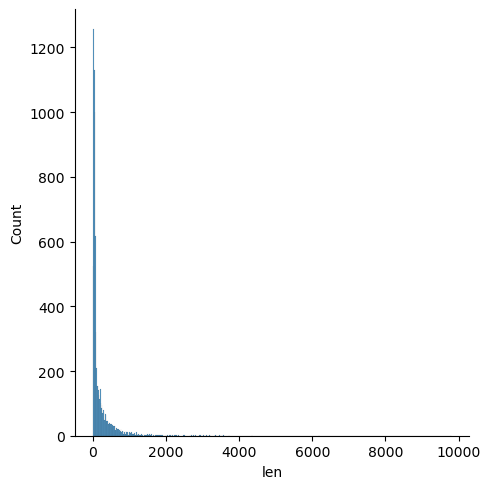

In [17]:
df['len'] = df['text'].apply(len)
sns.displot(df['len'])

In [23]:
df['len'].quantile(0.95)

750.0

### truncating lengths of sentences

In [24]:
#tuncating to 750 chars
len_ind = list(df[df['len']>=750].index)
for i in len_ind:
    df['text'].loc[i] = df['text'].loc[i][:750]

In [26]:
df.drop('len',axis=1,inplace=True)

<Axes: xlabel='label', ylabel='count'>

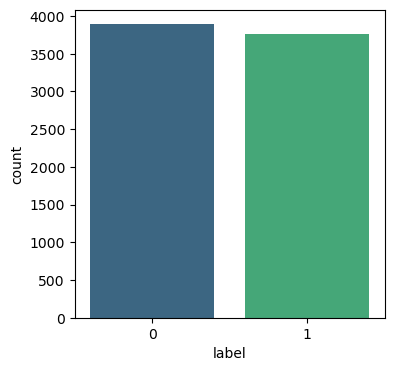

In [34]:
plt.figure(figsize=(4,4))
sns.countplot(x='label',data=df,palette='viridis')

In [35]:
from ydata_profiling import ProfileReport
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [92]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = df['text']
y = df['label']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

### Dtree

In [96]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train_tfidf,y_train)
pred_dtree = dtree.predict(X_test_tfidf)
print(classification_reportication_report(y_test,pred_dtree))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       772
           1       0.93      0.91      0.92       752

    accuracy                           0.92      1524
   macro avg       0.92      0.92      0.92      1524
weighted avg       0.92      0.92      0.92      1524



### RFC

In [97]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train_tfidf,y_train)
pred_rfc = rfc.predict(X_test_tfidf)
print(classification_report(y_test,pred_rfc))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       772
           1       0.99      0.92      0.95       752

    accuracy                           0.96      1524
   macro avg       0.96      0.96      0.96      1524
weighted avg       0.96      0.96      0.96      1524



### Naive bayes

In [108]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)
pred_nb = nb.predict(X_test_tfidf)
print(classification_report(y_test,pred_nb))

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       772
           1       0.75      0.99      0.86       752

    accuracy                           0.84      1524
   macro avg       0.87      0.84      0.83      1524
weighted avg       0.87      0.84      0.83      1524



### SVM

In [103]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_tfidf,y_train)
pred_svm = svm.predict(X_test_tfidf)
print(classification_report(y_test,pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       772
           1       0.98      0.94      0.96       752

    accuracy                           0.96      1524
   macro avg       0.96      0.96      0.96      1524
weighted avg       0.96      0.96      0.96      1524



In [37]:
df.drop_duplicates(inplace=True)

### text pipeline

In [38]:
#reducing length
def spacy_tokenizer(text):
    clean_text = clean_lemm(text)
    return clean_text.split()

### building vocab from scratch

In [45]:
def build_vocab(text_iterator,specials=('<unk>','<pad>'),min_freq=2):
    token_count = defaultdict(int)
    for text in text_iterator:
        for token in spacy_tokenizer(text):
            token_count[token] += 1
    vocab = {token:idx for idx,(token,count) in enumerate(token_count.items()) if count >= min_freq}
    for special in specials:
        if special not in vocab:
            vocab[special] = len(vocab)
    return vocab

In [46]:
vocab = build_vocab(df['text'])

In [47]:
vocab_size = len(vocab)
print(f"vocab_size : {vocab_size}")

vocab_size : 6760


In [49]:
#text pipeline
text_pipeline = lambda x : [vocab.get(token,vocab['<unk>'] )for token in spacy_tokenizer(x)]
label_pipeline = lambda x : int(x)

### Custom Dataset

In [55]:
#datasets
class TextDataset(Dataset):
     
    def __init__(self,df,text_pipeline,label_pipeline):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist()
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return self.text_pipeline(text),self.label_pipeline(label)

In [56]:
train_df,test_df = train_test_split(df,test_size=0.2)

In [57]:
train_dataset = TextDataset(train_df,text_pipeline,label_pipeline)
test_dataset = TextDataset(test_df,text_pipeline,label_pipeline)

### custom collate function

In [67]:
#pad collate
def pad_collate(batch):
    text_list = []
    label_list = []
    for text,label in batch:
        label_list.append(label)
        text_list.append(torch.LongTensor(text))
    label_list = torch.LongTensor(label_list)
    text_list = pad_sequence(text_list,batch_first=True)
    return text_list.to(device),label_list.to(device)

### dataloader objects

In [169]:
train_batch_size = 64
test_batch_size = len(test_dataset)
train_loader = DataLoader(train_dataset,train_batch_size,shuffle=True,collate_fn=pad_collate)
test_loader = DataLoader(test_dataset,test_batch_size,shuffle=False,collate_fn=pad_collate)

### LSTM

In [69]:
class LSTM(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size=2,num_layers=2,bidirectional=False,p=0.4):
        super(LSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.dropout = nn.Dropout(p)
        
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir * hidden_size,out_size)
        
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        lstm_out,hidden = self.lstm(embeddings,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [99]:
lstm = LSTM(vocab_size,32,16,out_size=2,num_layers=2,bidirectional=False,p=0.4).to(device)

In [100]:
lstm

LSTM(
  (embedding): Embedding(6760, 32)
  (dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(32, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=2, bias=True)
)

### training params

In [101]:
num_epochs = 10
optimizer = torch.optim.Adam(lstm.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()

In [102]:
import time
from tqdm import tqdm

start = time.time()
for epoch in range(num_epochs):
    lstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = lstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10: 100%|████████████████| 191/191 [00:33<00:00,  5.70it/s, loss=0.7034]


Epoch 1/10, Average Loss: 0.7053


Epoch 2/10: 100%|████████████████| 191/191 [00:33<00:00,  5.74it/s, loss=0.3507]


Epoch 2/10, Average Loss: 0.6231


Epoch 3/10: 100%|████████████████| 191/191 [00:32<00:00,  5.81it/s, loss=0.1047]


Epoch 3/10, Average Loss: 0.3145


Epoch 4/10: 100%|████████████████| 191/191 [00:33<00:00,  5.76it/s, loss=0.0427]


Epoch 4/10, Average Loss: 0.1625


Epoch 5/10: 100%|████████████████| 191/191 [00:33<00:00,  5.77it/s, loss=0.1400]


Epoch 5/10, Average Loss: 0.1284


Epoch 6/10: 100%|████████████████| 191/191 [00:33<00:00,  5.75it/s, loss=0.0192]


Epoch 6/10, Average Loss: 0.1057


Epoch 7/10: 100%|████████████████| 191/191 [00:32<00:00,  5.79it/s, loss=0.0857]


Epoch 7/10, Average Loss: 0.0878


Epoch 8/10: 100%|████████████████| 191/191 [00:32<00:00,  5.81it/s, loss=0.0138]


Epoch 8/10, Average Loss: 0.0941


Epoch 9/10: 100%|████████████████| 191/191 [00:32<00:00,  5.92it/s, loss=0.0153]


Epoch 9/10, Average Loss: 0.0772


Epoch 10/10: 100%|███████████████| 191/191 [00:32<00:00,  5.81it/s, loss=0.0097]

Epoch 10/10, Average Loss: 0.0658
Total training time: 5.50 minutes


In [104]:
all_preds = []
all_labels = []

lstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = lstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       753
           1       0.97      0.92      0.95       771

    accuracy                           0.95      1524
   macro avg       0.95      0.95      0.95      1524
weighted avg       0.95      0.95      0.95      1524



### BiLSTM

In [109]:
class BILSTM(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size=2,num_layers=2,bidirectional=False,p=0.4):
        super(BILSTM,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.dropout = nn.Dropout(p)
        
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir * hidden_size,out_size)
        
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        lstm_out,hidden = self.lstm(embeddings,hidden)
        lstm_out = self.dropout(lstm_out)
        pred = self.fc(lstm_out[:,-1,:])
        return pred
    
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device),
                 torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [170]:
bilstm = BILSTM(vocab_size,200,32,out_size=2,num_layers=2,bidirectional=True,p=0.4).to(device)

In [173]:
import time
from tqdm import tqdm
num_epochs = 5
optimizer = torch.optim.Adam(bilstm.parameters(),lr=0.0025)
criterion = nn.CrossEntropyLoss()
start = time.time()
for epoch in range(num_epochs):
    bilstm.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = bilstm(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/5: 100%|███████████████████| 96/96 [00:33<00:00,  2.86it/s, loss=0.0403]


Epoch 1/5, Average Loss: 0.0148


Epoch 2/5: 100%|███████████████████| 96/96 [00:32<00:00,  3.00it/s, loss=0.0000]


Epoch 2/5, Average Loss: 0.0084


Epoch 3/5: 100%|███████████████████| 96/96 [00:31<00:00,  3.01it/s, loss=0.0002]


Epoch 3/5, Average Loss: 0.0069


Epoch 4/5: 100%|███████████████████| 96/96 [00:32<00:00,  2.98it/s, loss=0.0015]


Epoch 4/5, Average Loss: 0.0075


Epoch 5/5: 100%|███████████████████| 96/96 [00:32<00:00,  2.96it/s, loss=0.0000]

Epoch 5/5, Average Loss: 0.0055
Total training time: 2.70 minutes


In [174]:
all_preds = []
all_labels = []

bilstm.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred = bilstm(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       753
           1       0.95      0.95      0.95       771

    accuracy                           0.95      1524
   macro avg       0.95      0.95      0.95      1524
weighted avg       0.95      0.95      0.95      1524



### GRU

In [121]:
class GRU(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size=2,num_layers=2,bidirectional=False,p=0.4):
        super(GRU,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.dropout = nn.Dropout(p)
        
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir * hidden_size,out_size)
        
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        gru_out,hidden = self.gru(embeddings,hidden)
        gru_out = self.dropout(gru_out)
        pred = self.fc(gru_out[:,-1,:])
        return pred
    
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [122]:
gru = GRU(vocab_size,64,16,out_size=2,num_layers=2,bidirectional=False,p=0.4).to(device)

In [123]:
import time
from tqdm import tqdm
num_epochs = 10
optimizer = torch.optim.Adam(gru.parameters(),lr=0.005)
criterion = nn.CrossEntropyLoss()
start = time.time()
for epoch in range(num_epochs):
    gru.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = gru(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/10: 100%|████████████████| 191/191 [01:03<00:00,  3.00it/s, loss=0.2133]


Epoch 1/10, Average Loss: 0.3562


Epoch 2/10: 100%|████████████████| 191/191 [01:00<00:00,  3.18it/s, loss=0.2067]


Epoch 2/10, Average Loss: 0.1141


Epoch 3/10: 100%|████████████████| 191/191 [01:00<00:00,  3.16it/s, loss=0.0377]


Epoch 3/10, Average Loss: 0.0700


Epoch 4/10: 100%|████████████████| 191/191 [01:00<00:00,  3.15it/s, loss=0.0424]


Epoch 4/10, Average Loss: 0.0453


Epoch 5/10: 100%|████████████████| 191/191 [01:02<00:00,  3.08it/s, loss=0.1318]


Epoch 5/10, Average Loss: 0.0344


Epoch 6/10: 100%|████████████████| 191/191 [01:01<00:00,  3.09it/s, loss=0.2076]


Epoch 6/10, Average Loss: 0.0312


Epoch 7/10: 100%|████████████████| 191/191 [01:00<00:00,  3.13it/s, loss=0.0015]


Epoch 7/10, Average Loss: 0.0340


Epoch 8/10: 100%|████████████████| 191/191 [01:00<00:00,  3.16it/s, loss=0.0143]


Epoch 8/10, Average Loss: 0.0202


Epoch 9/10: 100%|████████████████| 191/191 [01:00<00:00,  3.16it/s, loss=0.0016]


Epoch 9/10, Average Loss: 0.0141


Epoch 10/10: 100%|███████████████| 191/191 [01:00<00:00,  3.15it/s, loss=0.0032]

Epoch 10/10, Average Loss: 0.0121
Total training time: 10.18 minutes


In [124]:
all_preds = []
all_labels = []

gru.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred =gru(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       753
           1       0.90      0.98      0.94       771

    accuracy                           0.93      1524
   macro avg       0.94      0.93      0.93      1524
weighted avg       0.94      0.93      0.93      1524



In [128]:
class BIGRU(nn.Module):
    
    def __init__(self,vocab_size,embedding_dim,hidden_size,out_size=2,num_layers=2,bidirectional=False,p=0.4):
        super(BIGRU,self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.num_dir = 2 if bidirectional else 1
        
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.dropout = nn.Dropout(p)
        
        self.gru = nn.GRU(embedding_dim,hidden_size,num_layers=num_layers,bidirectional=bidirectional,batch_first=True)
        self.fc = nn.Linear(self.num_dir * hidden_size,out_size)
        
    def forward(self,x):
        hidden = self.init_hidden(x.size(0))
        embeddings = self.embedding(x)
        gru_out,hidden = self.gru(embeddings,hidden)
        gru_out = self.dropout(gru_out)
        pred = self.fc(gru_out[:,-1,:])
        return pred
    
    def init_hidden(self,batch_size):
        hidden = (torch.zeros(self.num_dir*self.num_layers,batch_size,self.hidden_size).to(device))
        return hidden

In [154]:
bigru = BIGRU(vocab_size,64,32,out_size=2,num_layers=2,bidirectional=True,p=0.6).to(device)

In [164]:
import time
from tqdm import tqdm
num_epochs = 1
optimizer = torch.optim.Adam(bigru.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
start = time.time()
for epoch in range(num_epochs):
    bigru.train()
    # Wrap your train_loader with tqdm
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    total_loss = 0
    for text, label in pbar:
        optimizer.zero_grad()
        y_pred = bigru(text)
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()
        
        # Update total loss and progress bar
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

print(f"Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/1: 100%|█████████████████| 191/191 [01:32<00:00,  2.06it/s, loss=0.0005]

Epoch 1/1, Average Loss: 0.0081
Total training time: 1.54 minutes


In [165]:
all_preds = []
all_labels = []

bigru.eval()
with torch.no_grad():
    for text, label in test_loader:
        pred =bigru(text)
        pred = torch.argmax(pred, dim=1)
        
        # Collect predictions and labels
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

# Now, use classification_report with the collected predictions and labels
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95       753
           1       0.97      0.94      0.95       771

    accuracy                           0.95      1524
   macro avg       0.95      0.95      0.95      1524
weighted avg       0.95      0.95      0.95      1524

